# Introduction to physics informed neural networks

This example, inspired by [this repo](https://github.com/benmoseley/harmonic-oscillator-pinn), introduces physics informed neural networks using pytorch. Here, we will learn the dynamics of a 1D dampened harmonic oscillator with unit mass, spring constant $k$ and dampening constant $\mu$:
$$
\dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~.
$$


Exercises:

(a) Run sections 1 and 2. It should work out of the box. Understand how the neural network is learning the dynamics and what are its short comings? Experiment with the hyperparameters (in capitals) and see if you can get the model to generalise better outside the domain.

(b) Train a physics informed neural network on the same data and plot the results. Experiment with hyper parameters and data parameters. (Section 3)

(c) Train a physics informed neural network but learn the parameters $\mu$ and $k$ (i.e., treat them as unknown parameters, section 4). 

(d) Add noise and repeat the experiments.

In [1]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn as nn
except ModuleNotFoundError:
    %pip install -r requirements.txt 


np.random.seed(0)
torch.random.manual_seed(0)

plt.rcParams['font.size'] = 16
plt.rcParams['lines.markersize'] = 10


### 1. Exact solution and data
For the underdampened case, $\mu^2 < 4 k~,$ the exact solution is given by 
$$
x(t) = e^{-\delta t}(A \cos(\phi + \omega t)),
$$
where $\omega=\frac{1}{2}\sqrt{4k - \mu^2}$ and the constants $A$ and $\phi$ determine the initial conditions. We will set $A=1$ and $\phi=0$. In practice however, we are given a data set that is the solution of a differential equation and we make the *assumption* that the differential equation is of a known form (i.e., we know the physical equations, possibly with some unknown constants that can be learned).

Let's turn the above exact solution into a function that we can use to generate a training data set $X_{\mathrm{train}}$ consisting of points $(t_i, x_i)$, where $t_i$ are evenly spaced times on some interval and $x_i=x(t_i)$ is given by the above exact solution. We wil also create a test data set $X_{\mathrm{test}}$ on a longer time interval. 

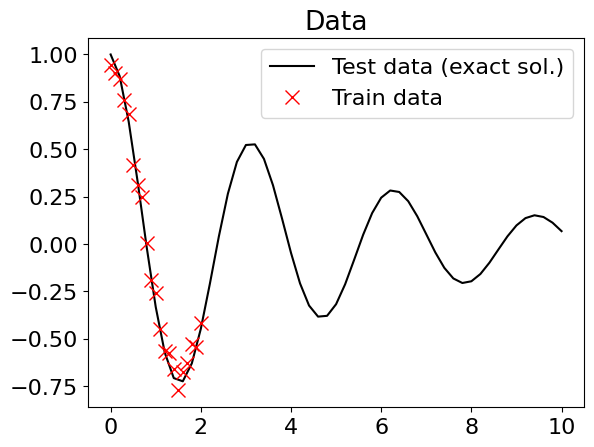

In [2]:
# ODE parameters
MU = 0.4
K = 4

# Data generation parameters
N_TRAIN = 20
TMAX_TRAIN = 2
NOISE_STD = 0.05

N_TEST = 50
TMAX_TEST = 10


def exact_solution(t, k=K, mu=MU):
    """Get exact solution to the 1D underdamped harmonic oscillator."""
    assert mu**2 < 4 * k, "System must be underdamped."
    w = np.sqrt(4 * k - mu**2) / 2
    x = torch.exp(-mu / 2 * t) * torch.cos(w * t)
    return x


t_train = torch.linspace(0, TMAX_TRAIN, N_TRAIN + 1).unsqueeze(-1)
t_test = torch.linspace(0, TMAX_TEST, N_TEST + 1).unsqueeze(-1)

x_train = exact_solution(t_train) + NOISE_STD * torch.randn_like(t_train)
x_test = exact_solution(t_test)

plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.title("Data")
plt.legend()

### 2. Learning the dynamics with a ***basic neural network*** 
Now we will set up a neural network $x_\theta(t)$ to learn the dynamics $x(t)$ from the training data. We hope that it will generalise well to the test data, which is the exact solution over a longer time span. 

We do this by training the neural network on a loss function that minimises the mean squared error (MSE) between the predicted solution $x_{\theta}(t_i)$ and the observed (exact solution) values $(t_i, x_i)\in X_{\mathrm{train}}$. 

$$L_{\mathrm{data}} = \sum_{(t_i, x_i)\in X_{\mathrm{train}}}\|x_{\theta}(t_i) - x_i\|^2$$

loss = 0.3999679684638977
loss = 0.0018866354366764426
loss = 0.0015609734691679478
loss = 0.0015143948839977384
loss = 0.00148978759534657
loss = 0.0014670544769614935
loss = 0.001399643486365676
loss = 0.001098432345315814
loss = 0.0005901543772779405
loss = 0.0003103483759332448
loss = 0.00022194806660991162
loss = 0.00014031074533704668
loss = 0.00012257798516657203
loss = 0.00011592406372074038
loss = 0.00010468820983078331
loss = 0.0001273053785553202
loss = 8.152083319146186e-05
loss = 0.00015376441297121346
loss = 5.199128281674348e-05
loss = 3.825273597612977e-05


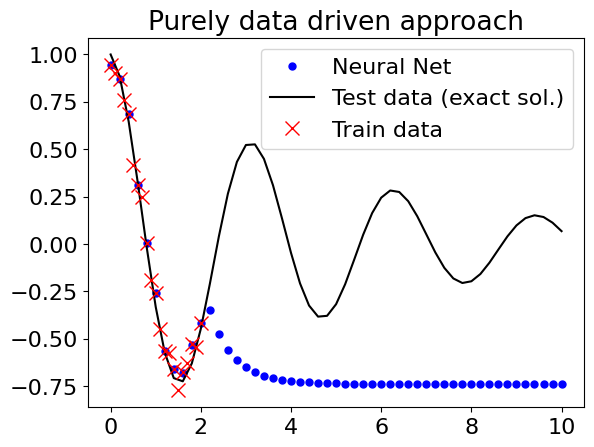

In [3]:
class NeuralNet(nn.Module):
    """Defines a pytorch neural network with one hidden layer."""

    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.network(x)


def train_nn(model, t_train, x_train, nepochs=10000, learning_rate=5e-3):
    mse = nn.MSELoss()
    torch.manual_seed(123)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(nepochs):
        optimizer.zero_grad()

        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train)

        # backward pass and update parameters
        loss.backward()
        optimizer.step()

        print(f"loss = {loss.item()}") if i % 500 == 0 else None


model_nn = NeuralNet()
train_nn(model_nn, t_train=t_train, x_train=x_train)

plt.plot(t_test, model_nn(t_test).detach().numpy(), "b.", label="Neural Net")
plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.title("Purely data driven approach")
plt.legend()

### 3. Learning the dynamics with a ***physics informed neural network***
Now we will train the physics informed neural network (PINN). This is done in exactly the same way as before, but we augment the loss function with the "physics loss".

$$L_{\mathrm{PINN}}=L_{\mathrm{data}} + \lambda L_{\mathrm{phys.}}$$
where $\lambda$ is a hyper parameter
$$L_{\mathrm{phys.}} = \sum_{t_i\in X_{\mathrm{phys.}}}\|\ddot{x}_{\theta}(t_i)+ \mu\,\dot{x}_{\theta}(t_i) + k\,x_{\theta}(t_i)\|^2,$$
where $X_{\mathrm{phys.}}$ are a set of times, chosen by us, that we choose to evaluate the *physics loss* on 

In [4]:
# choose points to evaluate the physics loss with
TMAX_PHYS = 7
N_PHYS = 200

t_phys = np.random.uniform(0, TMAX_PHYS, N_PHYS)

model_pinn = NeuralNet(1, 32, 1)


def time_derivative(x, t):
    """Returns the time derivative of x at times t using automatic differentiation.
    Example: 
        t = torch.linspace(0, 1, 10)
        x = model(t)
        xdot = time_derivative(x, t)"""
    xdot = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    return xdot


def train_pinn(model, t_train, x_train, t_phys, nepochs=10000, learning_rate=5e-3):
    lambda_ = 1e-2
    mse = nn.MSELoss()
    t_phys = torch.tensor(t_phys, requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(nepochs):
        optimizer.zero_grad()

        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train)

        # compute physics loss
        x_phys = model(t_phys)
        xdot = time_derivative(x_phys, t_phys)
        xddot = time_derivative(xdot, t_phys)
        ode_residual = xddot + MU * xdot + K * x_phys
        loss += lambda_ * torch.mean(ode_residual**2)

        # backward pass and update params
        loss.backward()
        optimizer.step()
        print(f"loss = {loss.item()}") if i % 500 == 0 else None


train_pinn(model_pinn, t_train, x_train, t_phys)

loss = 0.29802924394607544
loss = 0.0032725967466831207
loss = 0.002747295657172799
loss = 0.0023733247071504593
loss = 0.0022355467081069946
loss = 0.0021654502488672733
loss = 0.002106050495058298
loss = 0.0019538900814950466
loss = 0.001853826455771923
loss = 0.0018165181390941143
loss = 0.0017709251260384917
loss = 0.0016963885864242911
loss = 0.0016439377795904875
loss = 0.0016341537702828646
loss = 0.001630023238249123
loss = 0.001900081755593419
loss = 0.0016266581369563937
loss = 0.0016256158705800772
loss = 0.0016276343958452344
loss = 0.0016242851270362735


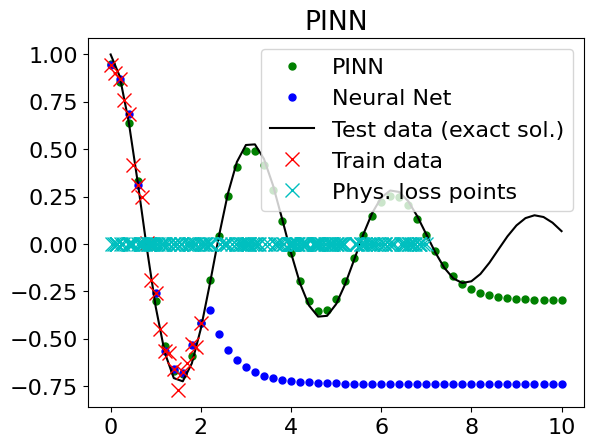

In [5]:
plt.plot(t_test, model_pinn(t_test).detach().numpy(), "g.", label="PINN")
plt.plot(t_test, model_nn(t_test).detach().numpy(), "b.", label="Neural Net")
plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.plot(t_phys, 0 * t_phys, "cx", label="Phys. loss points")
plt.title("PINN")
plt.legend()

### 4. Learning the parameters $\mu$ and $k$

What we have just done was solve the forward problem. Traditional numerics usually beats PINNs in terms of cost and accuracy. However, the scenario where PINNs outperforms traditional numerics is when we have ***partial*** knowledge of the governing equations. 

Say that the parameters $\mu$ and $k$ are unknown. Using the data (which encodes the values of $\mu$ and $k$) together with knowledge that the governing ODE is partially known, we can treat $\mu$ and $k$ as learnable parameters and adopt the same approach as before. 

In [6]:
class PINN(nn.Module):
    """Defines a pytorch neural network with one hidden layer and trainable parameters."""

    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()

        # Tell the pytorch module to learn the parameters:
        self.mu = nn.Parameter(torch.tensor(0.0, requires_grad=True))
        self.k = nn.Parameter(torch.tensor(0.0, requires_grad=True))

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.network(x)


def train_pinn(model, t_train, x_train, t_phys, nepochs=10000, learning_rate=5e-3):
    lambda_ = 1e-1
    mse = nn.MSELoss()
    t_phys = torch.tensor(t_phys, requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(nepochs):
        optimizer.zero_grad()

        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train)

        # compute physics loss (same as before with parameters mu and k added to back propagation step)
        mu = model.mu
        k = model.k
        x_phys = model(t_phys)
        xdot = time_derivative(x_phys, t_phys)
        xddot = time_derivative(xdot, t_phys)
        ode_residual = xddot + mu * xdot + k * x_phys
        loss += lambda_ * torch.mean(ode_residual**2)

        # backward pass and update params
        loss.backward()
        optimizer.step()
        print(f"loss = {loss.item()}") if i % 500 == 0 else None


model_pinn2 = PINN(1, 32, 1)

train_pinn(model_pinn2, t_train, x_train, t_phys)

loss = 0.29869452118873596
loss = 0.014426582492887974
loss = 0.007876183837652206
loss = 0.006115482654422522
loss = 0.003984492737799883
loss = 0.00375954108312726
loss = 0.0035633486695587635
loss = 0.0032949792221188545
loss = 0.0022155605256557465
loss = 0.0016844485653564334
loss = 0.0016496372409164906
loss = 0.0016365868505090475
loss = 0.001630824408493936
loss = 0.0016361811431124806
loss = 0.0016238404205068946
loss = 0.0016398642910644412
loss = 0.0016224464634433389
loss = 0.0016225144499912858
loss = 0.0016228273743763566
loss = 0.0016505657695233822


Learned \mu = 0.39863887429237366, exact \mu = 0.4
learned k = 4.189992427825928, exact k = 4


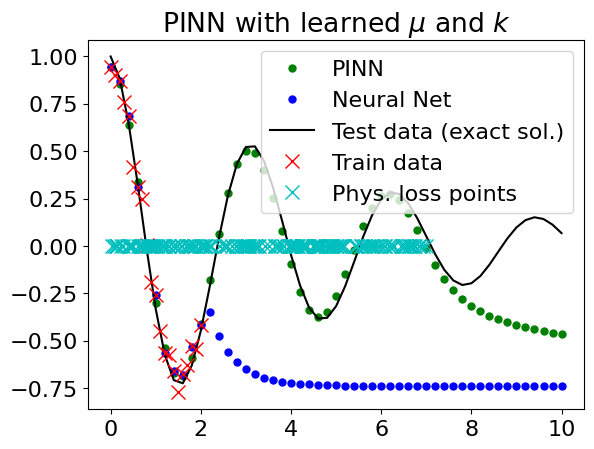

In [7]:
print(
    f"Learned \mu = {model_pinn2.mu.item()}, exact \mu = {MU}\nlearned k = {model_pinn2.k.item()}, exact k = {K}"
)

plt.plot(t_test, model_pinn2(t_test).detach().numpy(), "g.", label="PINN")
plt.plot(t_test, model_nn(t_test).detach().numpy(), "b.", label="Neural Net")
plt.plot(t_test, x_test, "k-", label="Exact solution")
plt.plot(t_train, x_train, "rx", label="Noisy data")
plt.plot(t_phys, 0 * t_phys, "cx", label="Phys. loss points")
plt.title("PINN with learned $\mu$ and $k$")
plt.legend()
